## Day 27 Lecture 1 Assignment

In this assignment, we will learn statistical significance in linear models. We will use the google play store dataset loaded below and analyze the regression from this dataset.

In [1]:
%matplotlib inline
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, normalize, MinMaxScaler
from scipy.stats import bartlett
from scipy.stats import levene
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

In [3]:
reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We will predict app ratings using other features describing the app. To use these features, we must clean the data.

To simplify, we will remove the app, category, size, installs, genres, last updated, current ver, and android ver columns. 

In [4]:
# answer below:
feature_df = reviews.copy()
feature_df.drop(['App', 'Category', 'Size', 'Installs', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], axis =1, inplace=True)
feature_df

,Rating,Reviews,Type,Price,Content Rating
0,4.1,159,Free,0,Everyone
1,3.9,967,Free,0,Everyone
2,4.7,87510,Free,0,Everyone
3,4.5,215644,Free,0,Teen
4,4.3,967,Free,0,Everyone
...,...,...,...,...,...
10836,4.5,38,Free,0,Everyone
10837,5.0,4,Free,0,Everyone
10838,NaN,3,Free,0,Everyone
10839,4.5,114,Free,0,Mature 17+


Check for missing values and remove all rows containing missing values

In [5]:
# answer below:
missing_report = feature_df.isnull().sum()/feature_df.isnull().count()
missing_report

Rating            0.135965
Reviews           0.000000
Type              0.000092
Price             0.000000
Content Rating    0.000092
dtype: float64

In [6]:
feature_df.dropna(inplace=True)
missing_report = feature_df.isnull().sum()/feature_df.isnull().count()
missing_report

Rating            0.0
Reviews           0.0
Type              0.0
Price             0.0
Content Rating    0.0
dtype: float64

Remove outliers from the Type and Content Rating columns (very rare values that won't train well).

In [7]:
# answer below:
feature_df['Type'].value_counts()

Free    8719
Paid     647
Name: Type, dtype: int64

In [8]:
feature_df['Content Rating'].value_counts()

Everyone           7420
Teen               1084
Mature 17+          461
Everyone 10+        397
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [9]:
feature_df.drop(feature_df[feature_df['Content Rating']=='Unrated'].index, inplace=True)
feature_df.drop(feature_df[feature_df['Content Rating']=='Adults only 18+'].index, inplace=True)

In [10]:
feature_df['Content Rating'].value_counts()

Everyone        7420
Teen            1084
Mature 17+       461
Everyone 10+     397
Name: Content Rating, dtype: int64

Convert the Type and Content Rating columns to a numeric format, whether by one-hot encoding, ordinal encoding, or similar.

In [11]:
# answer below:
feature_df = pd.concat([feature_df,
                        pd.get_dummies(feature_df['Type'], prefix='type', drop_first=True)],
                       axis=1)

feature_df = pd.concat([feature_df,
                        pd.get_dummies(feature_df['Content Rating'], prefix='ContentRating', drop_first=True)],
                       axis=1)

feature_df.drop(['Type','Content Rating'], axis=1, inplace=True)

In [12]:
feature_df.head()

,Rating,Reviews,Price,type_Paid,ContentRating_Everyone 10+,ContentRating_Mature 17+,ContentRating_Teen
0,4.1,159,0,0,0,0,0
1,3.9,967,0,0,0,0,0
2,4.7,87510,0,0,0,0,0
3,4.5,215644,0,0,0,0,1
4,4.3,967,0,0,0,0,0


Finally, check that all the columns are of numeric type and change the type of columns that are not numeric. If coercing to numeric causes missing values, remove those rows containing missing values from our dataset.

In [13]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9362 entries, 0 to 10840
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rating                      9362 non-null   float64
 1   Reviews                     9362 non-null   object 
 2   Price                       9362 non-null   object 
 3   type_Paid                   9362 non-null   uint8  
 4   ContentRating_Everyone 10+  9362 non-null   uint8  
 5   ContentRating_Mature 17+    9362 non-null   uint8  
 6   ContentRating_Teen          9362 non-null   uint8  
dtypes: float64(1), object(2), uint8(4)
memory usage: 329.1+ KB


In [14]:
feature_df['Reviews'] = pd.to_numeric(feature_df['Reviews'], errors='coerce', downcast='integer')

In [15]:
feature_df['Price'] = feature_df['Price'].str.strip('$')

In [16]:
feature_df['Price'] = feature_df['Price'].astype(float)

In [17]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9362 entries, 0 to 10840
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rating                      9362 non-null   float64
 1   Reviews                     9362 non-null   int32  
 2   Price                       9362 non-null   float64
 3   type_Paid                   9362 non-null   uint8  
 4   ContentRating_Everyone 10+  9362 non-null   uint8  
 5   ContentRating_Mature 17+    9362 non-null   uint8  
 6   ContentRating_Teen          9362 non-null   uint8  
dtypes: float64(2), int32(1), uint8(4)
memory usage: 292.6 KB


Perform a train test split with 20% of the data in the test sample.

In [18]:
# answer below:
X = feature_df.drop(['Rating'], axis=1)
y = feature_df[['Rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now generate a linear model using statsmodels and produce a p value for each coefficient in the model. Analyze the results. (Look at the results table and at a homoscedasticity plot.)

In [19]:
# answer below:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     12.37
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           6.61e-14
Time:                        23:50:28   Log-Likelihood:                -5617.8
No. Observations:                7489   AIC:                         1.125e+04
Df Residuals:                    7482   BIC:                         1.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

All the p-values are less than 0.05, therefore the coefficients are significant (not zero)

In [20]:
lrm = linear_model.LinearRegression()

lrm.fit(X_train, y_train)
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)
errors = y_test['Rating'] - y_preds
print(f'Coefs: {lrm.coef_}')
print(f'Intercept: {lrm.intercept_}')
print(f'Mean of errors: {np.mean(errors)}')

Coefs: [[ 0.00000000e+00  1.19567797e-08 -9.91132536e-04  1.09357473e-01
   5.39806566e-02 -5.66441457e-02  4.67438169e-02]]
Intercept: [4.17286641]
Mean of errors: 0.00599945918439066


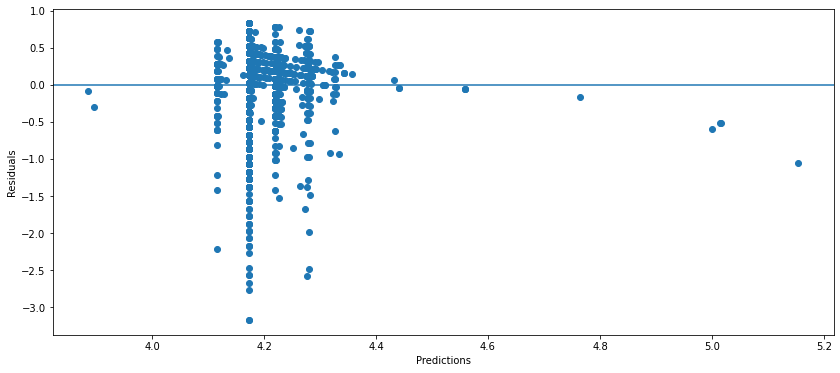

In [21]:
plt.figure(figsize=(14,6))
plt.scatter(y_preds, errors)
plt.axhline(y=0)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

In [22]:
bart_stats = bartlett(y_preds, errors)
lev_stats = levene(y_preds, errors)

print('Bartlett test:')
print(bart_stats)
print('Levene test:')
print(lev_stats)

Bartlett test:
BartlettResult(statistic=5502.718610552975, pvalue=0.0)
Levene test:
LeveneResult(statistic=1247.1677180877548, pvalue=4.637421908342998e-236)


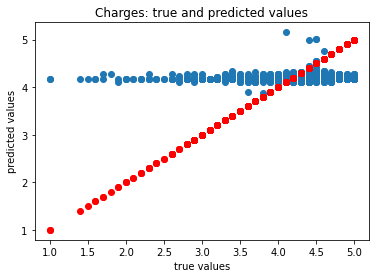

In [23]:
plt.scatter(y_test['Rating'], y_preds)
plt.scatter(y_test['Rating'], y_test['Rating'], color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Scale your predictors and refit the linear model.

* How does this change the coefficients?
* How does this change the coefficients' p values?
* How does this change model performance?

In [28]:
# answer below:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
y_train_scaled = y_train.copy()
y_test_scaled = y_test.copy()

X_train_scaled.drop(['const'], axis=1, inplace=True)
X_test_scaled.drop(['const'], axis=1, inplace=True)

# quantile = QuantileTransformer(output_distribution='normal')
# scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

for col in X_train_scaled.columns:
  X_train_scaled[col] = minmax_scaler.fit_transform(X_train_scaled[[col]])

for col in X_test_scaled.columns:
  X_test_scaled[col] = minmax_scaler.fit_transform(X_test_scaled[[col]])

y_train_scaled['Rating'] = minmax_scaler.fit_transform(y_train_scaled[['Rating']])

y_test_scaled['Rating'] = minmax_scaler.fit_transform(y_test_scaled[['Rating']])

In [29]:
X_train_scaled = sm.add_constant(X_train_scaled)
results = sm.OLS(y_train_scaled, X_train_scaled).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     12.37
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           6.61e-14
Time:                        23:51:08   Log-Likelihood:                 4764.1
No. Observations:                7489   AIC:                            -9514.
Df Residuals:                    7482   BIC:                            -9466.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
lrm = linear_model.LinearRegression()

lrm.fit(X_train_scaled, y_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)
y_preds_scaled = results.predict(X_test_scaled)
errors_scaled = np.array(y_test_scaled['Rating'])-np.array(y_preds_scaled)
print(f'Coefs: {lrm.coef_}')
print(f'Intercept: {lrm.intercept_}')
print(f'Mean of errors: {np.mean(errors_scaled)}')

Coefs: [[ 0.          0.23354044 -0.09911325  0.02733937  0.01349516 -0.01416104
   0.01168595]]
Intercept: [0.7932166]
Mean of errors: 0.0015005770370407716


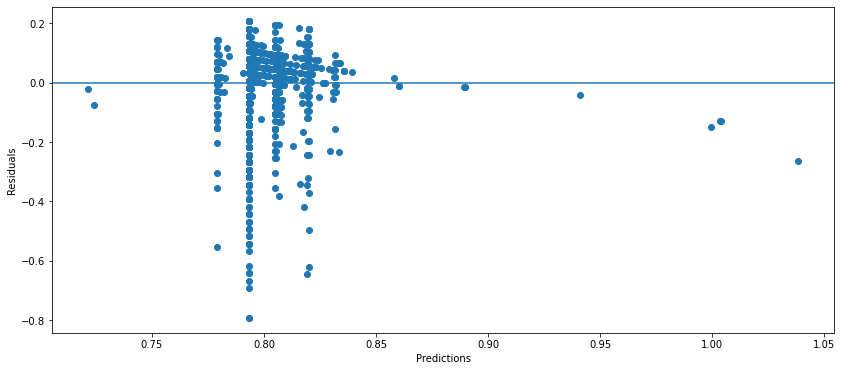

In [33]:
plt.figure(figsize=(14,6))
plt.scatter(y_preds_scaled, errors_scaled)
plt.axhline(y=0)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

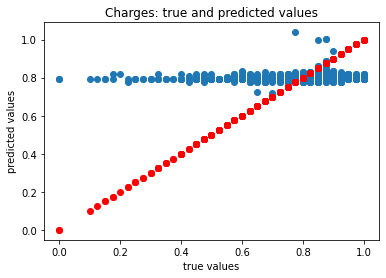

In [35]:
plt.scatter(y_test_scaled['Rating'], y_preds_scaled)
plt.scatter(y_test_scaled['Rating'], y_test_scaled['Rating'], color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Using the MinMax scaler doesn't really do much to help the model fit the data.